<a href="https://colab.research.google.com/github/JefNtungila/DS-Unit-2-Classification-1/blob/master/Assignment_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment Random Forest

In [1]:
!pip install category_encoders

     |████████████████████████████████| 92kB 5.8MB/s 


In [3]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
pd.set_option('display.float_format', '{:.2f}'.format)

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('https://drive.google.com/uc?export=download&id=14ULvX0uOgftTB2s97uS8lIx1nHGQIB0P'), 
                 pd.read_csv('https://drive.google.com/uc?export=download&id=1r441wLr7gKGHGLyPpKauvCuUOU556S2f'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1wvsYl9hbRbZuIuoaLWCsW_kbcxCdocHz')
sample_submission = pd.read_csv('https://drive.google.com/uc?export=download&id=1kfJewnmhowpUo381oSn3XqsQ6Eto23XV')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

# Print dataframe shapes
print('train', train.shape)
print('val', val.shape)
print('test', test.shape)

train (47520, 41)
val (11880, 41)
test (14358, 40)


##Cleaning data

In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [6]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaler: fit_transform on train, transform on val & test
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Model: Fit on train, score on val, predict on test
model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

Validation Accuracy 0.7281986531986532


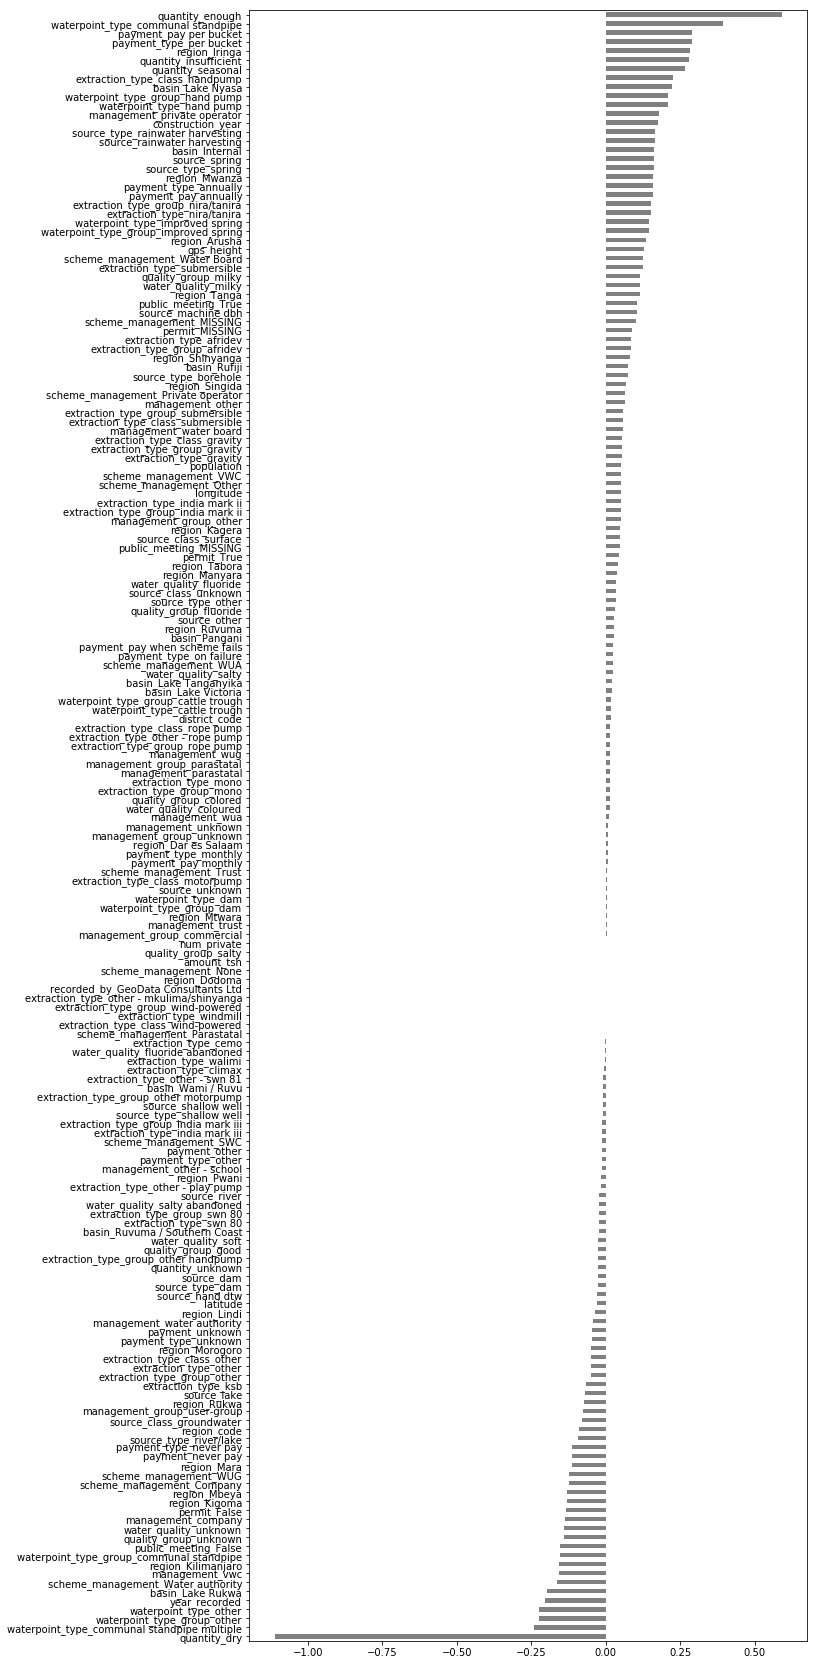

In [7]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [17]:
X_train_encoded.columns.values

array(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year',
       'year_recorded', 'basin_Lake Nyasa', 'basin_Rufiji',
       'basin_Wami / Ruvu', 'basin_Lake Victoria', 'basin_Internal',
       'basin_Lake Tanganyika', 'basin_Pangani', 'basin_Lake Rukwa',
       'basin_Ruvuma / Southern Coast', 'region_Mbeya', 'region_Iringa',
       'region_Pwani', 'region_Kagera', 'region_Dodoma', 'region_Rukwa',
       'region_Arusha', 'region_Mwanza', 'region_Mtwara', 'region_Tanga',
       'region_Kilimanjaro', 'region_Manyara', 'region_Lindi',
       'region_Kigoma', 'region_Morogoro', 'region_Shinyanga',
       'region_Ruvuma', 'region_Tabora', 'region_Mara', 'region_Singida',
       'region_Dar es Salaam', 'public_meeting_True',
       'public_meeting_False', 'public_meeting_MISSING',
       'recorded_by_GeoData Consultants Ltd', 'scheme_management_VWC',
       'scheme_management_WUA', 'scheme_management_

In [0]:
train_location = X_train_encoded[[ 'longitude', 'latitude', 'region_code', 'payment_never pay',
       'payment_pay monthly', 'payment_pay per bucket', 'payment_unknown',
       'payment_pay annually', 'payment_pay when scheme fails',
       'payment_other', 'payment_type_never pay', 'payment_type_monthly',
       'payment_type_per bucket', 'payment_type_unknown',
       'payment_type_annually', 'payment_type_on failure',
       'payment_type_other', 'quality_group_good', 'quality_group_salty',
       'quality_group_fluoride', 'quality_group_milky',
       'quality_group_unknown', 'quality_group_colored',
       'quantity_insufficient', 'quantity_enough', 'quantity_dry',
       'quantity_seasonal', 'quantity_unknown' ]].copy()
val_location = X_val_encoded[[ 'longitude', 'latitude', 'region_code', 'payment_never pay',
       'payment_pay monthly', 'payment_pay per bucket', 'payment_unknown',
       'payment_pay annually', 'payment_pay when scheme fails',
       'payment_other', 'payment_type_never pay', 'payment_type_monthly',
       'payment_type_per bucket', 'payment_type_unknown',
       'payment_type_annually', 'payment_type_on failure',
       'payment_type_other', 'quality_group_good', 'quality_group_salty',
       'quality_group_fluoride', 'quality_group_milky',
       'quality_group_unknown', 'quality_group_colored',
       'quantity_insufficient', 'quantity_enough', 'quantity_dry',
       'quantity_seasonal', 'quantity_unknown']].copy()

##Logistic regression

In [30]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
lr.fit(train_location, y_train)
print('Logistic Regression')
print('Train Accuracy', lr.score(train_location, y_train))
print('Validation Accuracy', lr.score(val_location, y_val))

Logistic Regression
Train Accuracy 0.6541666666666667
Validation Accuracy 0.6603535353535354


##Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=20)
dt.fit(train_location, y_train)
print('Decision Tree')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree
Train Accuracy 0.990719696969697
Validation Accuracy 0.7121212121212122


In [32]:
dt = DecisionTreeClassifier(random_state=20, max_depth=25)
dt.fit(train_location, y_train)
print('Decision Tree')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree
Train Accuracy 0.9729166666666667
Validation Accuracy 0.7142255892255892


##Random Forest

In [35]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8023569023569024
CPU times: user 30.1 s, sys: 532 ms, total: 30.6 s
Wall time: 18.3 s


##Submitting to kaggle

In [0]:
all(X_test_encoded.columns == X_train_encoded.columns)

True

In [0]:
y_pred = model.predict(X_test_scaled)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-01.csv', index=False)

In [0]:
!head submission-01.csv

id,status_group
50785,non functional
51630,functional
17168,non functional
45559,non functional
49871,functional
52449,functional
24806,functional
28965,non functional
36301,functional


In [0]:
from google.colab import files
files.download('submission-01.csv')